In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
from scipy import stats
from scipy.stats import norm
plt.style.use('ggplot')
sys.path.append(os.path.abspath("../../shared"))
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import eda
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import feature_selection
import helpers
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

## This is how we dropped na values in other notebook

In [3]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
data = data.drop((missing_data[missing_data['Total'] > 1]).index,1)
data = data.drop(data.loc[data['Electrical'].isnull()].index)
print(data.isnull().any().any())

False


## Get baseline model as quick as possible

In [4]:
def random_forest_train_and_test(X):
    train = X.copy()
    num_features, cat_features = helpers.nc_features(train)
    train = helpers.label_encode(train, cat_features)
    target = data.SalePrice
    train = train.drop('SalePrice',1)
    random_forest_baseline = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42);
    random_forest_baseline.fit(train, target);
    
    # From the docs, The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a 
    # bootstrap sample of the training observations z_i = (x_i, y_i). The out-of-bag (OOB) error is the average error for 
    # each z_i calculated using predictions from the trees that do not contain z_i in their respective bootstrap sample
    # The study of error estimates for bagged classifiers in Breiman [1996b], gives empirical evidence to show that the out-of-bag 
    # estimate is as accurate as using a test set of the same size as the training set. Source: https://www.quora.com/What-is-the-out-of-bag-error-in-random-forests-What-does-it-mean-Whats-a-typical-value-if-any-Why-would-it-be-higher-or-lower-than-a-typical-value
    print('oob_score: ', random_forest_baseline.oob_score_)
    target_oob = random_forest_baseline.oob_prediction_
    # For this metric, the higher the number (max is 1), the better the predictions
    print('explained_variance_score = ', metrics.explained_variance_score(target, target_oob))
    # A otal of 17597 dollars off over the entire training set, not bad
    print('mean_absolute_error = ', metrics.mean_absolute_error(target, target_oob))

In [5]:
#random_forest_train_and_test(data)

### Feature Engineering + Outlier Removal + Data transformations

1 -> Outlier Removal

In [6]:
#temp = data.copy()
print('Correlation before removing outliers:', data.LotArea.corr(data['SalePrice']))
data = data.loc[data['LotArea'] <= 100000]
#sns.regplot(x='LotArea', data=data,y='SalePrice', color='blue', scatter_kws={'alpha':.25})
#plt.xlabel('np.log(LotArea)')
print('Correlation after removing outliers:', data.LotArea.corr(data['SalePrice']))

Correlation before removing outliers: 0.263837415181
Correlation after removing outliers: 0.35449097997


In [7]:
#sns.regplot(x='GrLivArea', y='SalePrice',color='blue', data=data, ci=95); plt.title('Before removing outliers'); plt.show();
data = data.loc[data['GrLivArea'] < 4000]
#sns.regplot(x='GrLivArea', y='SalePrice',color='blue', data=data, ci=95); plt.title('After removing outliers'); 

2 -> Data transformations

In [8]:
#f, ax = plt.subplots(2,2); ax = np.ndarray.flatten(ax); sns.distplot(data['GrLivArea'], fit=norm, ax=ax[0]); res = stats.probplot(data['GrLivArea'], plot=ax[2]);
data['GrLivArea'] = np.log(data['GrLivArea'])
#sns.distplot(data['GrLivArea'], fit=norm, ax=ax[1]); res = stats.probplot(data['GrLivArea'], plot=ax[3]); plt.tight_layout();

In [9]:
#f, ax = plt.subplots(2,2); ax = np.ndarray.flatten(ax); sns.distplot(data['SalePrice'], fit=norm, ax=ax[0]); res = stats.probplot(data['SalePrice'], plot=ax[2]);
data['SalePrice'] = np.log(data['SalePrice'])
#sns.distplot(data['SalePrice'], fit=norm, ax=ax[1]); res = stats.probplot(data['SalePrice'], plot=ax[3]); plt.tight_layout();

3 -> Feature engineering

In [10]:
data['TotalSquareFeet'] = data['GrLivArea'] + data['TotalBsmtSF']
data['BathTotal'] = data['FullBath'] + data['HalfBath']
data['BsmtBathTotal'] = data['BsmtFullBath'] + data['BsmtHalfBath']
data['TotalBsmtFinSF'] = data['BsmtFinSF2'] + data['BsmtFinSF1']

data['OverallQuality'] = data['OverallQual'] * data['OverallCond']

qual_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
data['ExterCond'] = data['ExterCond'].map(qual_mapping)
data['ExterQual'] = data['ExterQual'].map(qual_mapping)
data['ExteriorScore'] = data['ExterCond'] + data['ExterQual']

data['KitchenQual'] = data['KitchenQual'].map(qual_mapping)
data['KitchenScore'] = data['KitchenQual'] * data['KitchenAbvGr']

porch_and_deck_features = [f for f in data.columns if 'Deck' in f or 'Porch' in f]
data['TotalPorchDeckSF'] = 0
for f in porch_and_deck_features:
    data['TotalPorchDeckSF'] += data[f]

In [11]:
#random_forest_train_and_test(data)

In [24]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

data = pd.get_dummies(data)
### Copying features
data_no_target = data.copy()
data_no_target = data_no_target.drop('SalePrice', 1)
# Reshape into a single column, n rows 
target = data['SalePrice'].values.reshape(-1,1)

#data_train, data_test, target_train, target_test = train_test_split(data_no_target, target, test_size=0.33, random_state=42)

# NOTE: xtrain and ytrain are numpy/normal arrays
def rmse_cv(estimator, xtrain, ytrain, cv=3):
    kfold = KFold(n_splits=cv)
    results = list()
    
    for train_idx, test_idx in kfold.split(xtrain):
        estimator.fit(xtrain[train_idx], ytrain[train_idx])
        predicted = estimator.predict(xtrain[test_idx])
        actual = ytrain[test_idx]
        mse = mean_squared_error(predicted, actual)
        rmse = np.sqrt(mse)
        results.append(rmse)
        
    return np.array(results).mean()

print(data_no_target.shape)
print(target.shape)

(1451, 218)
(1451, 1)


In [25]:
data.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalSquareFeet,BathTotal,BsmtBathTotal,TotalBsmtFinSF,OverallQuality,ExteriorScore,KitchenScore,TotalPorchDeckSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,4,3,706,0,150,856,856,854,0,7.444249,1,0,2,1,3,1,4,8,0,2,548,0,61,0,0,0,0,0,2,2008,12.247694,863.444249,3,1,706,35,7,4,61,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,3,3,978,0,284,1

In [26]:
data_no_target.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSquareFeet,BathTotal,BsmtBathTotal,TotalBsmtFinSF,OverallQuality,ExteriorScore,KitchenScore,TotalPorchDeckSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,4,3,706,0,150,856,856,854,0,7.444249,1,0,2,1,3,1,4,8,0,2,548,0,61,0,0,0,0,0,2,2008,863.444249,3,1,706,35,7,4,61,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,3,3,978,0,284,1262,1262,0,0,7.14045

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm1 = LinearRegression()
rmse_cv(lm1, data_no_target.values, target)

657.0406639133688

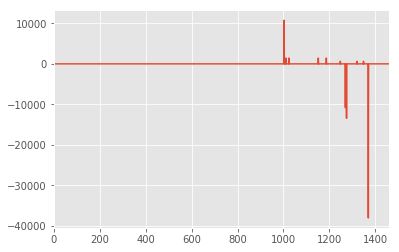

In [28]:
# Reshape into single row, mutiple columns (normal array)
predicted = pd.Series(lm1.predict(data_no_target.values).reshape(-1), index=data_no_target.index)
residual = predicted - target.reshape(-1)
residual = pd.Series([float(item) for item in residual], index=data_no_target.index)
residual.plot();

In [31]:
scores = cross_val_score(lm1, data_no_target.values, target, cv=50)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -65601334.15 (+/- 561895641.24)
